In [123]:
import pandas as pd
import sys
import os

notebook_dir = os.path.abspath('')

scripts_dir = os.path.join(os.path.dirname(notebook_dir), 'scripts')
sys.path.append(scripts_dir)

# 引入先前寫過判斷打席結果與方向的函式
from categorize_at_bat_result import categorize_at_bat_result
# 引入 25 宮格的轉換函式
from map_to_25_grid import map_to_25_grid


# 引入已清理過的逐球記錄
cleaned_labled_file_path = '../labeled/jose_ramos_pitches_df_cleaned.csv'

pitches_df = pd.read_csv(cleaned_labled_file_path)

print("DataFrame Shape:", pitches_df.shape)


DataFrame Shape: (93, 27)


In [124]:
# 引入打席記錄
abs_path = "../labeled/50_abs_jose_ramos_20240308.csv"
abs_df = pd.read_csv(abs_path)
abs_df.head(1)


,abs_id,file_name,file_name_date,file_name_player_name,file_name_pitcher_type,file_name_at_bat_number,file_name_result,is_filename_result_consistent,inning,at_bat_result,weather,game_time
0,1,2022-09-10 Jose Ramos VS 右投 打席2_二飛.mp4,2022-09-10,Jose Ramos,RHP,2,二飛,True,4,4F,sunny,day


In [125]:
# 多了  'any_on_base', 'base_combination' 
pitches_df.columns


Index(['id', 'abs_id', 'nth_pitch_ab', 'out_count', 'strike_count',
       'ball_count', 'is_rhp', 'has_stealing_attempt', 'pitch_type',
       'pitch_release', 'is_obvious_off_zone', 'is_pitch_ended_catcher_want',
       'has_swing', 'has_first_base_runner', 'has_second_base_runner',
       'has_third_base_runner', 'has_visible_shift', 'score_diffrence',
       'is_team_leading', 'has_swing_intention', 'horizontal_ending',
       'vertical_ending', 'is_swing_delayed', 'is_swing_early', 'is_whiff',
       'any_on_base', 'base_combination'],
      dtype='object')

In [126]:
pitches_df.head(1)


,id,abs_id,nth_pitch_ab,out_count,strike_count,ball_count,is_rhp,has_stealing_attempt,pitch_type,pitch_release,...,score_diffrence,is_team_leading,has_swing_intention,horizontal_ending,vertical_ending,is_swing_delayed,is_swing_early,is_whiff,any_on_base,base_combination
0,4e1e4436-2ba9-41a0-b88a-5cc4641edcbe,1,1,0,0,0,True,False,slider,overhand,...,1,True,False,outside,low,False,False,False,False,0


## 什麼樣的球會打成安打？

In [127]:
# 計算打席結果比例
abs_df['at_bat_result_group'] = abs_df['at_bat_result'].apply(categorize_at_bat_result)

group_counts = abs_df['at_bat_result_group'].value_counts(normalize=True) * 100

print(group_counts)


at_bat_result_group
三振     34.0
安打     20.0
飛球     18.0
滾地球    18.0
保送     10.0
Name: proportion, dtype: float64


In [128]:
# 只有標記一半的打席
# 所有打席最後一球

last_pitches = pitches_df.loc[pitches_df.groupby('abs_id')['nth_pitch_ab'].idxmax()]


last_pitches['ending_combination'] = last_pitches['horizontal_ending'] + '_' + last_pitches['vertical_ending']

total_ending_combinations = last_pitches['ending_combination'].value_counts()

total_ending_combinations


ending_combination
outside_low       8
middle_high       7
outside_middle    3
middle_middle     2
outside_high      2
inside_middle     2
inside_high       1
middle_low        1
Name: count, dtype: int64

In [129]:

# 每個安打打席的最後一球
hits_abs_ids = abs_df[abs_df['at_bat_result_group'] == '安打']['abs_id']

hits_pitches = pitches_df[pitches_df['abs_id'].isin(hits_abs_ids)]

last_pitches_of_hits = hits_pitches.loc[hits_pitches.groupby('abs_id')[
    'nth_pitch_ab'].idxmax()]

last_pitches_of_hits.head(1)

,id,abs_id,nth_pitch_ab,out_count,strike_count,ball_count,is_rhp,has_stealing_attempt,pitch_type,pitch_release,...,score_diffrence,is_team_leading,has_swing_intention,horizontal_ending,vertical_ending,is_swing_delayed,is_swing_early,is_whiff,any_on_base,base_combination
11,6fbaf895-e887-4592-ab42-d0b8315c538a,4,4,1,2,1,False,False,slider,overhand,...,1,True,True,outside,low,False,False,False,True,110


In [130]:
# 看有無 off zone 的安打
last_pitches_of_hits[last_pitches_of_hits['is_obvious_off_zone'] == True].shape[0]


0

In [131]:
# 根據球種
hit_pitch_type_proportions = last_pitches_of_hits['pitch_type'].value_counts(normalize=True) * 100

hit_pitch_type_proportions

pitch_type
slider       66.666667
curve        16.666667
four_seam    16.666667
Name: proportion, dtype: float64

In [132]:
# 合併 horizontal_ending 和 vertical_ending 成為一個新的組合欄位
last_pitches_of_hits['ending_combination'] = last_pitches_of_hits['horizontal_ending'] + '_' + last_pitches_of_hits['vertical_ending']

# 計算每種組合的佔比
off_zone_proportion = last_pitches_of_hits['ending_combination'].value_counts(normalize=True) * 100

print(off_zone_proportion)


ending_combination
outside_low       33.333333
middle_middle     16.666667
middle_high       16.666667
middle_low        16.666667
outside_middle    16.666667
Name: proportion, dtype: float64


In [133]:
# 計算安打率

hits_last_pitches = last_pitches[last_pitches['abs_id'].isin(hits_abs_ids)]
hits_ending_combinations = hits_last_pitches['ending_combination'].value_counts()

print(hits_ending_combinations)


hit_rates = (hits_ending_combinations / total_ending_combinations)
hit_rates


ending_combination
outside_low       2
middle_middle     1
middle_high       1
middle_low        1
outside_middle    1
Name: count, dtype: int64


ending_combination
inside_high            NaN
inside_middle          NaN
middle_high       0.142857
middle_low        1.000000
middle_middle     0.500000
outside_high           NaN
outside_low       0.250000
outside_middle    0.333333
Name: count, dtype: float64

In [134]:
# 各進壘點安打率
import itertools
hit_rates_df = hit_rates.reset_index()
hit_rates_df.columns = ['ending_combination', 'hit_rate']

hit_rates_df[['horizontal_ending', 'vertical_ending']] = hit_rates_df['ending_combination'].str.split('_', expand=True)

# ensure all 9 spots are included
expected_combinations = pd.DataFrame(list(itertools.product(['inside', 'middle', 'outside'], ['high', 'middle', 'low'])),
                                     columns=['horizontal_ending', 'vertical_ending'])
expected_combinations['ending_combination'] = expected_combinations['horizontal_ending'] + '_' + expected_combinations['vertical_ending']

# merge
full_hit_rates_df = pd.merge(expected_combinations, hit_rates_df[['ending_combination', 'hit_rate']], on='ending_combination', how='left')


full_hit_rates_df

,horizontal_ending,vertical_ending,ending_combination,hit_rate
0,inside,high,inside_high,NaN
1,inside,middle,inside_middle,NaN
2,inside,low,inside_low,NaN
3,middle,high,middle_high,0.142857
4,middle,middle,middle_middle,0.500000
5,middle,low,middle_low,1.000000
6,outside,high,outside_high,NaN
7,outside,middle,outside_middle,0.333333
8,outside,low,outside_low,0.250000


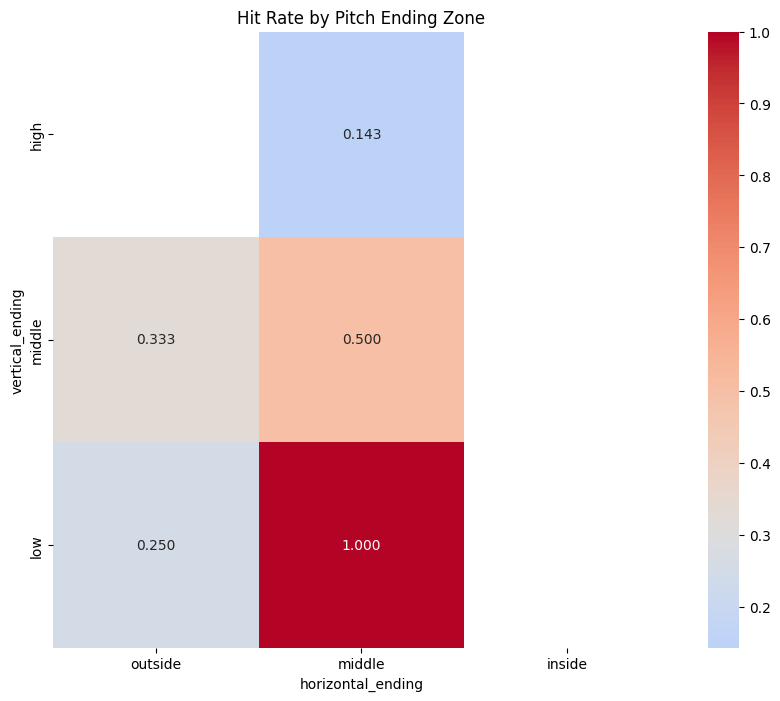

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt

# other method here
# last_pitches_of_hits_data = {
#     'horizontal_ending': ['inside', 'outside', 'middle', 'inside', 'outside', 'middle', 'outside', 'middle', 'inside'],
#     'vertical_ending': ['high', 'high', 'high',  'middle', 'middle', 'middle', 'low', 'low', 'low'],

#     'hit_rate': hit_rates_df,
# }

# last_pitches_of_hits = pd.DataFrame(last_pitches_of_hits_data)

# pivot_table = last_pitches_of_hits.pivot(index='vertical_ending',
#                                          columns='horizontal_ending', values='hit_rate')

pivot_table = hit_rates_df.pivot(index='vertical_ending', columns='horizontal_ending', values='hit_rate').reindex(
    columns=['inside', 'middle', 'outside'], index=['high', 'middle', 'low'])


expected_vertical_order = ['high', 'middle', 'low']
expected_horizontal_order = ['outside', 'middle', 'inside']


pivot_table_reordered = pivot_table.reindex(index=expected_vertical_order,
                                            columns=expected_horizontal_order)


# cmap = sns.diverging_palette(240, 10, n=9, center="light", as_cmap=True)

plt.figure(figsize=(10, 8))
# sns.heatmap(pivot_table_reordered, annot=True,
#             fmt=".3f", cmap=cmap, square=True)
sns.heatmap(pivot_table_reordered, annot=True, fmt=".3f", cmap='coolwarm', square=True, center=0.3)

plt.title("Hit Rate by Pitch Ending Zone")
plt.show()


### 並且在 off zone 的所有區塊，都沒有形成安打
可能是小樣本造成

## 進壘點分析

要把九宮格的 mapping 到 D-O 位置

正四方的偏位獨立

其他地方放到AAA類似的


In [136]:
### 25 宮格
# AABCC
# ADEFC
# GHIJK
# LMNOP
# LLQPP


In [137]:
# 建立進壘點記數
pitch_location_grouped_df = pitches_df.groupby(
    ['is_obvious_off_zone', 'horizontal_ending', 'vertical_ending'])

pitch_location_df = pitch_location_grouped_df.size().reset_index(name='counts')

pitch_location_df


,is_obvious_off_zone,horizontal_ending,vertical_ending,counts
0,False,inside,high,5
1,False,inside,low,3
2,False,inside,middle,7
3,False,middle,high,7
4,False,middle,low,5
5,False,middle,middle,5
6,False,outside,high,6
7,False,outside,low,16
8,False,outside,middle,7
9,True,inside,high,5


In [138]:
# 建立 25 宮格分組
pitches_df['25_grid'] = pitches_df.apply(map_to_25_grid, axis=1)

pitches_df[['is_obvious_off_zone', 'horizontal_ending', 'vertical_ending', '25_grid']].head(3)


,is_obvious_off_zone,horizontal_ending,vertical_ending,25_grid
0,False,outside,low,M
1,False,middle,high,E
2,False,outside,high,D


In [139]:
# 看有沒有沒被歸類到的
pitches_df[pitches_df['25_grid'] == 'unknown'].shape[0]

0

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

overall_pitch_location_counts = pitches_df['25_grid'].value_counts()
overall_pitch_location_counts


25_grid
M    16
L    13
E     7
J     7
H     7
D     6
B     6
A     6
I     5
C     5
N     5
F     5
O     3
Q     1
P     1
Name: count, dtype: int64

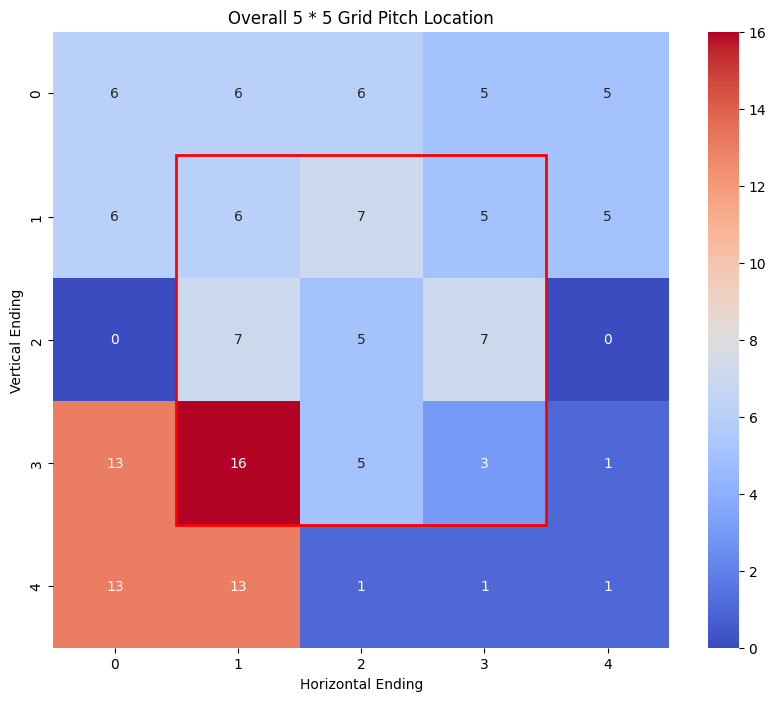

In [141]:

# 原先 mapping
# grid_mapping = {
#     'A': (0, 0), 'A': (0, 1), 'B': (0, 2), 'C': (0, 3), 'C': (0, 4),
#     'A': (1, 0), 'D': (1, 1), 'E': (1, 2), 'F': (1, 3), 'C': (1, 4),
#     'G': (2, 0), 'H': (2, 1), 'I': (2, 2), 'J': (2, 3), 'K': (2, 4),
#     'L': (3, 0), 'M': (3, 1), 'N': (3, 2), 'O': (3, 3), 'P': (3, 4),
#     'L': (4, 0), 'L': (4, 1), 'Q': (4, 2), 'P': (4, 3), 'P': (4, 4),
# }


# for grid, count in grid_counts.items():
#     if grid in grid_mapping:
#         x, y = grid_mapping[grid]
#         heatmap_data[x, y] = count


from matplotlib import patches

grid_map = {
    'A': [(0, 0), (0, 1), (1, 0)],
    'B': [(0, 2)],
    'C': [(0, 3), (0, 4), (1, 4)],
    'D': [(1, 1)],
    'E': [(1, 2)],
    'F': [(1, 3)],
    'G': [(2, 0)],
    'H': [(2, 1)],
    'I': [(2, 2)],
    'J': [(2, 3)],
    'K': [(2, 4)],
    'L': [(3, 0), (4, 0), (4, 1)],
    'M': [(3, 1)],
    'N': [(3, 2)],
    'O': [(3, 3)],
    'P': [(3, 4), (4, 3), (4, 4)],
    'Q': [(4, 2)],
}


overall_pitch_location_heatmap = np.zeros((5, 5))


for letter, positions in grid_map.items():
    count = overall_pitch_location_counts.get(letter, 0)
    for x, y in positions:
        overall_pitch_location_heatmap[x, y] += count

# 嘗試隱藏 其他例如 A 格子只留一格
# annot_arr = np.array(heatmap_data, dtype=str)
# annot_arr = np.array([[f"{val:.2f}" for val in row] for row in heatmap_data])


# hide_annot_indices = [
#     (0, 1), (1, 0),  # 对于 'A'
#     (0, 4), (1, 4),  # 对于 'C'
#     (4, 0), (4, 1),  # 对于 'L'
#     (4, 3), (4, 4)   # 对于 'P'
# ]

# for x, y in hide_annot_indices:
#     annot_arr[x, y] = ''
# ax = sns.heatmap(heatmap_data, annot=annot_arr, cmap="coolwarm", square=True)


plt.figure(figsize=(10, 8))

# center_data = overall_pitch_location_heatmap[1:4, 1:4]

ax = sns.heatmap(overall_pitch_location_heatmap, annot=True, fmt=".0f",
                 cmap="coolwarm", square=True)


# 中間九宮格紅線
ax.add_patch(patches.Rectangle(
    (1, 1), 3, 3, fill=False, edgecolor='red', linewidth=2))


# TODO: 外角分組
# rectangles = {
#     'A': {'start': (0, 0), 'width': 2, 'height': 2},
#     'C': {'start': (0, 3), 'width': 2, 'height': 2},
#     'L': {'start': (3, 0), 'width': 2, 'height': 2},
#     'P': {'start': (3, 3), 'width': 2, 'height': 2},
# }

# for rect in rectangles.values():
#     ax.add_patch(patches.Rectangle(rect['start'], rect['width'], rect['height'],
#                                    linewidth=2, edgecolor='yellow', facecolor='none'))


plt.title("Overall 5 * 5 Grid Pitch Location")
plt.xlabel("Horizontal Ending")
plt.ylabel("Vertical Ending")
plt.show()


### 根據左右投

In [142]:
# 左右投不同
pitches_rhp = pitches_df[pitches_df['is_rhp'] == True].copy()
pitches_lhp = pitches_df[pitches_df['is_rhp'] == False].copy()

pitches_rhp['25_grid'] = pitches_rhp.apply(map_to_25_grid, axis=1)
pitches_lhp['25_grid'] = pitches_lhp.apply(map_to_25_grid, axis=1)

print("RHP:")
print(pitches_rhp[['is_rhp', 'horizontal_ending', 'vertical_ending', '25_grid']].head(3))

print("LHP:")
print(pitches_lhp[['is_rhp', 'horizontal_ending', 'vertical_ending', '25_grid']].head(3))


RHP:
   is_rhp horizontal_ending vertical_ending 25_grid
0    True           outside             low       M
1    True            middle            high       E
5    True           outside             low       M
LHP:
   is_rhp horizontal_ending vertical_ending 25_grid
2   False           outside            high       D
3   False            middle          middle       I
4   False            middle            high       B


In [143]:

rhp_pitch_location_counts = pitches_rhp['25_grid'].value_counts()
rhp_pitch_location_counts

25_grid
L    12
M    10
E     5
J     5
H     5
C     5
N     4
I     3
F     3
O     2
D     2
B     1
Q     1
Name: count, dtype: int64

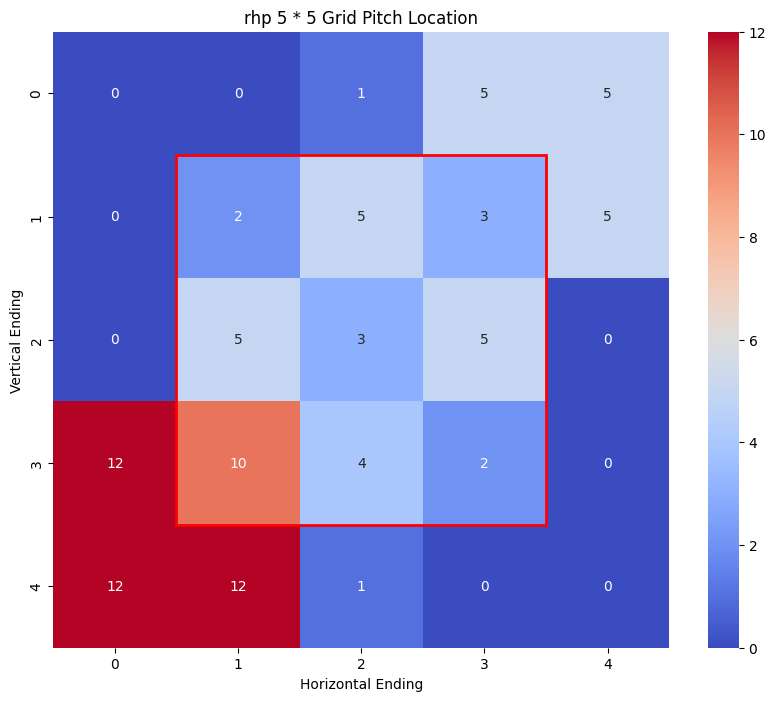

In [144]:
# 右投手進壘點圖表
rhp_pitch_location_heatmap = np.zeros((5, 5))


for letter, positions in grid_map.items():
    count = rhp_pitch_location_counts.get(letter, 0)
    for x, y in positions:
        rhp_pitch_location_heatmap[x, y] += count

plt.figure(figsize=(10, 8))


ax = sns.heatmap(rhp_pitch_location_heatmap, annot=True, fmt=".0f",
                 cmap="coolwarm", square=True)


ax.add_patch(patches.Rectangle(
    (1, 1), 3, 3, fill=False, edgecolor='red', linewidth=2))


plt.title("rhp 5 * 5 Grid Pitch Location")
plt.xlabel("Horizontal Ending")
plt.ylabel("Vertical Ending")
plt.show()


In [145]:

lhp_pitch_location_counts = pitches_lhp['25_grid'].value_counts()
lhp_pitch_location_counts

25_grid
M    6
A    6
B    5
D    4
I    2
E    2
J    2
H    2
F    2
L    1
N    1
P    1
O    1
Name: count, dtype: int64

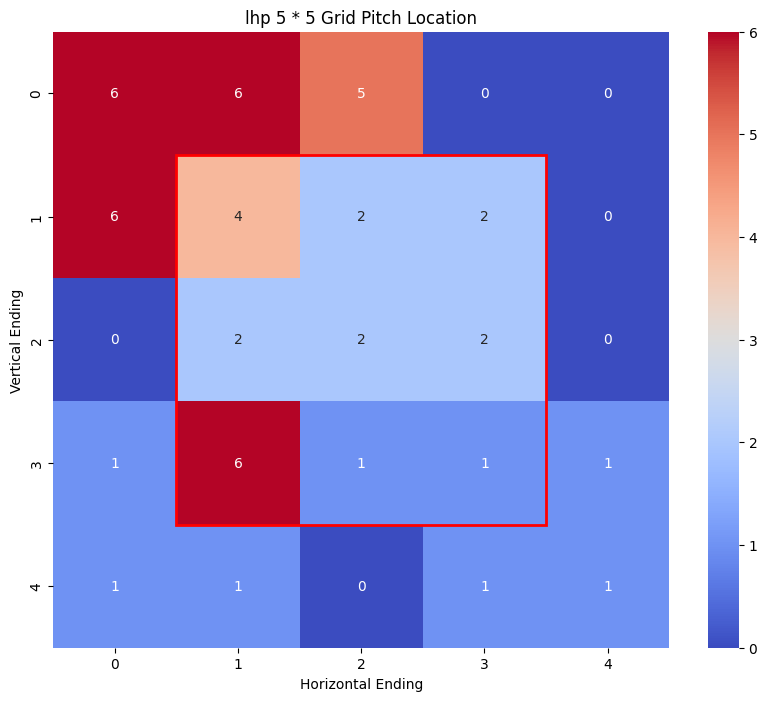

In [146]:
# 左投手進壘點圖表
lhp_pitch_location_heatmap = np.zeros((5, 5))


for letter, positions in grid_map.items():
    count = lhp_pitch_location_counts.get(letter, 0)
    for x, y in positions:
        lhp_pitch_location_heatmap[x, y] += count

plt.figure(figsize=(10, 8))


ax = sns.heatmap(lhp_pitch_location_heatmap, annot=True, fmt=".0f",
                 cmap="coolwarm", square=True)


ax.add_patch(patches.Rectangle(
    (1, 1), 3, 3, fill=False, edgecolor='red', linewidth=2))


plt.title("lhp 5 * 5 Grid Pitch Location")
plt.xlabel("Horizontal Ending")
plt.ylabel("Vertical Ending")
plt.show()



## 追打情形

In [147]:
obvious_off_zone_pitches = pitches_df.loc[pitches_df['is_obvious_off_zone'] == True]

print('obvious_off_zone_pitches row counts:')
print(obvious_off_zone_pitches.shape[0])

obvious_off_zone_pitches.head(1)

obvious_off_zone_pitches row counts:
32


,id,abs_id,nth_pitch_ab,out_count,strike_count,ball_count,is_rhp,has_stealing_attempt,pitch_type,pitch_release,...,is_team_leading,has_swing_intention,horizontal_ending,vertical_ending,is_swing_delayed,is_swing_early,is_whiff,any_on_base,base_combination,25_grid
4,04aed05c-1302-4121-bcc2-be9a8ef1a3c4,2,3,1,2,0,False,False,four_seam,overhand,...,True,True,middle,high,True,False,True,True,11,B


In [148]:
# 計算每種組合的佔比

obvious_off_zone_pitches_copy = obvious_off_zone_pitches.copy()

obvious_off_zone_pitches_copy['ending_combination'] = obvious_off_zone_pitches_copy['horizontal_ending'] + \
    '_' + obvious_off_zone_pitches_copy['vertical_ending']

off_zone_proportion = obvious_off_zone_pitches_copy['ending_combination'].value_counts(
    normalize=True) * 100

print(off_zone_proportion)


ending_combination
outside_low     40.625
middle_high     18.750
outside_high    18.750
inside_high     15.625
middle_low       3.125
inside_low       3.125
Name: proportion, dtype: float64
